In [23]:
import h5py 
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


f = h5py.File('mnist_traindata.hdf5','r') 
#f=h5py.File('mnist_network_params.hdf5','r')
list(f.keys())
#list(f1.keys())

['xdata', 'ydata']

In [24]:
xdata=f['xdata']
ydata=f['ydata']
xdata=np.array(xdata)
ydata=np.array(ydata)
xtrain,xval,ytrain,yval=train_test_split(xdata,ydata,test_size=0.16666)

In [25]:
def relu(x):
    return np.maximum(x, 0)

In [26]:
def relu_derivative(x):
    a=np.zeros((x.shape[0],x.shape[1]),float)
    for i in range(0,x.shape[0]):
        for j in range (0,x.shape[1]):
            if x[i,j]>0:
                a[i,j]=1
            elif x[i,j]==0:
                a[i,j]=np.random.uniform(0,1)
            else:
                a[i,j]=0
    return a

In [27]:
def tanh(x):
 #   if x>100:
  #      x=100
   # if x<-100:
    #    x=-100
    a=np.exp(x)
    b=np.exp(-x)
    y=(a-b)/(a+b)    
    return y

In [28]:
def tanh_derivative(x):
    a=np.exp(x)
    b=np.exp(-x)
    c=4/(a+b)
    return c

In [29]:
def Softmax(x):
    exp_scores = np.exp(x)
    out = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return out

In [30]:
def build_model(x,hidden_layers,hidden_nodes,output_dim=10): #could be 1 or 2 hiden layers
    model = {}
    input_dim = x.shape[1]
    if hidden_layers==1:
        model['hidden_layers']=1
        model['w1'] = np.random.randn(input_dim, hidden_nodes[0]) / np.sqrt(input_dim)
        model['b1'] = np.zeros((1, hidden_nodes[0]))
        model['w2'] = np.random.randn(hidden_nodes[0], output_dim) / np.sqrt(hidden_nodes)
        model['b2'] = np.zeros((1, output_dim))
    if hidden_layers==2:
        model['hidden_layers']=2
        model['w1'] = np.random.randn(input_dim, hidden_nodes[0]) / np.sqrt(input_dim)
        model['b1'] = np.zeros((1, hidden_nodes[0]))
        model['w2'] = np.random.randn(hidden_nodes[0], hidden_nodes[1]) / np.sqrt(hidden_nodes[0])
        model['b2'] = np.zeros((1, hidden_nodes[1]))    
        model['w3'] = np.random.randn(hidden_nodes[1], output_dim) / np.sqrt(hidden_nodes[1])
        model['b3'] = np.zeros((1, output_dim))        
    return model

In [31]:
def feed_forward_relu(model,x):
    hidden_layers, w1, b1, w2, b2 =model['hidden_layers'], model['w1'], model['b1'], model['w2'], model['b2']
    if hidden_layers==1:
        z1 = x.dot(w1) + b1
        a1 = relu(z1)
        z2 = a1.dot(w2) + b2
        out=  Softmax(z2)
        return z1,a1,z2,out
    if hidden_layers==2:
        w3,b3=model['w3'], model['b3']
        z1 = x.dot(w1) + b1
        a1 = relu(z1)
        z2 = a1.dot(w2) + b2
        a2 = relu(z2)
        z3 = a2.dot(w3) + b3
        out = Softmax(z3)
        return z1,a1,z2,a2,z3,out

In [32]:
def feed_forward_tanh(model,x):
    hidden_layers, w1, b1, w2, b2 =model['hidden_layers'], model['w1'], model['b1'], model['w2'], model['b2']
    if hidden_layers==1:
        z1 = x.dot(w1) + b1
        a1 = tanh(z1)
        z2 = a1.dot(w2) + b2
        out= Softmax(z2)
        return z1,a1,z2,out
    if hidden_layers==2:
        w3,b3=model['w3'], model['b3']
        z1 = x.dot(w1) + b1
        a1 = tanh(z1)
        z2 = a1.dot(w2) + b2
        a2 = tanh(z2)
        z3 = a2.dot(w3) + b3
        out = Softmax(z3)
        return z1,a1,z2,a2,z3,out

In [33]:
def cost_entropy(xtrain,ytrain):  #input xtrain and ytrain,output cost for each data
######################################   
    out=feed_forward_relu(model,xtrain)
   # out=feed_forward_tanh(model,xtrain)
########################################
    cost=out[-1]*ytrain
    c=cost.max(axis=1)
    cost_entropy=np.log(c)
    return cost_entropy

In [34]:
def backprop(x,y,model,forward_output):   #suppose 1 hidden layer is 20 nodes, 3 layer:  784-20-10, choose 50 data in one batch
# Wa+b  is a (50*20)*(20*10)+1*10 ---> get 50*10   output as a, will be 50*784 --50*20 --50*10 --
    hidden_layers=model['hidden_layers']
    n=x.shape[0]
    a1=forward_output[1]
    if hidden_layers==1:
        delta3 = forward_output[-1]-y    # delta3 is 50*10 (n data*predt_error)
        dw2 = (a1.T).dot(delta3)/n         # dw2 is same as w2, 20*10,  a1=20*1, 
        db2 = np.sum(delta3, axis=0, keepdims=True)/n #db2 is same as b2, 1*10
#################################################
       # delta2 = delta3.dot(model['w2'].T) * tanh_derivative(a1) #if tanh
        delta2 = delta3.dot(model['w2'].T) * relu_derivative(a1) #if ReLU
################################################
        dw1 = np.dot(x.T, delta2)/n
        db1 = np.sum(delta2, axis=0)/n
        return dw1, dw2, db1, db2
    if hidden_layers==2:
        a2=forward_output[3]
        delta3 = forward_output[-1]-y
        dw3 = (a2.T).dot(delta3)/n
        db3 = np.sum(delta3, axis=0, keepdims=True)/n
#####################################################
      #  delta2 = delta3.dot(model['w3'].T) * tanh_derivative(a2) #if tanh
        delta2 = delta3.dot(model['w3'].T) * relu_derivative(a2) #if ReLU
#####################################################
        dw2 = np.dot(a1.T, delta2)/n
        db2 = np.sum(delta2, axis=0)/n
#####################################################
      #  delta1 = delta2.dot(model['w2'].T) * tanh_derivative(a1) #if tanh
        delta1 = delta2.dot(model['w2'].T) * relu_derivative(a1) #if ReLU
#####################################################
        dw1 = np.dot(x.T, delta1)/n
        db1 = np.sum(delta1, axis=0)/n
        return dw1, dw2, dw3,db1,db2,db3

In [35]:
def train(x_train,y_train,x_val,y_val,model,lr=0.1,n_epoch=50,n_batch=50):
    # Batch gradient descent
    x=x_train
    y=y_train
#    n_epoch=100
#   n_batch=50  # define batch and epoch number
    n_update=int(x.shape[0]/n_batch)
    acu_val=np.zeros((n_epoch,1),float)
    acu_train=np.zeros((n_epoch,1),float)
    for j in range (0,n_epoch):
        if j==20:
            lr=lr/2
        if j==40:
            lr=lr/2
        xtrain,xval,ytrain,yval=train_test_split(x,y,test_size=0)  #shuffle x,y into xtrain,ytrain 
        for i in range (0,n_update):    
            x_batch=xtrain[i*50:i*50+50,:]
            y_batch=ytrain[i*50:i*50+50,:]
            #feed forward
#####################################################
            out_forward = feed_forward_relu(model, x_batch)
          #  out_forward = feed_forward_tanh(model, x_batch)
#####################################################
            #backpropagation
            #out_back = backprop(x_batch,y_batch,model,out_forward)  
            #update weights and biases
            if model['hidden_layers']==1:
                #backpropagation
                dw1, dw2, db1, db2= backprop(x_batch,y_batch,model,out_forward) # remember to change function in backprop
                model['w1'] =  model['w1']-lr * dw1
                model['b1'] =  model['b1']-lr * db1
                model['w2'] =  model['w2']-lr * dw2
                model['b2'] =  model['b2']-lr * db2
            if model['hidden_layers']==2:
                 #backpropagation
                dw1, dw2, dw3,db1,db2,db3= backprop(x_batch,y_batch,model,out_forward)  # remember to change function in backprop          
                model['w1'] =  model['w1']-lr * dw1
                model['b1'] =  model['b1']-lr * db1
                model['w2'] =  model['w2']-lr * dw2
                model['b2'] =  model['b2']-lr * db2
                model['w3'] =  model['w3']-lr * dw3
                model['b3'] =  model['b3']-lr * db3
        ytrain_pred=pred(model,xtrain)
        acu_train[j,0]=accuracy(ytrain_pred,ytrain)
        yval_pred=pred(model,x_val)
        acu_val[j,0]=accuracy(yval_pred,y_val)    
        print ("accuracy after %i iteration: %f train, %f validation  " %(j, acu_train[j,0],acu_val[j,0]))  #uncomment once testing finished
    model['acu_train']=acu_train
    model['acu_val']=acu_val
    print ("finish training")
    return model

In [36]:
def pred(model,x):
    n_iter=x.shape[0]
    pred_label=np.zeros((n_iter,10),float)
#####################################################
    out=feed_forward_relu(model, x)
   # out=feed_forward_tanh(model, x)
#####################################################
    pred_prob=out[-1]
    for i in range (0,n_iter):
        label=np.where(pred_prob[i,:]==np.max(pred_prob[i,:]))   # find label for each predict data
        pred_label[i,label[0]]=1        
    return pred_label

In [37]:
def accuracy(ypred,ytrue):
    n_error=0
    for i in range (0,ypred.shape[0]):
        n=ypred[i,:].dot(ytrue[i,:])
        if n==0:
            n_error=n_error+1    
    accuracy=1-n_error/ypred.shape[0]
    return accuracy

In [38]:

    # initiate model, with 2 hidden layers [400,70]
model1=build_model(xtrain,hidden_layers=2,hidden_nodes=[400,70],output_dim=10)  
    #train model, get model parameter and accuracy in each epoch
model1=train(xtrain,ytrain,xval,yval,model1,lr=0.05,n_epoch=25,n_batch=50)   # learning rate should less than 0.05
    


accuracy after 0 iteration: 0.922420 train, 0.915200 validation  
accuracy after 1 iteration: 0.944260 train, 0.936600 validation  
accuracy after 2 iteration: 0.954900 train, 0.944600 validation  
accuracy after 3 iteration: 0.966000 train, 0.955500 validation  
accuracy after 4 iteration: 0.971120 train, 0.960200 validation  
accuracy after 5 iteration: 0.975280 train, 0.962700 validation  
accuracy after 6 iteration: 0.979880 train, 0.966900 validation  
accuracy after 7 iteration: 0.981780 train, 0.965800 validation  
accuracy after 8 iteration: 0.984840 train, 0.970700 validation  
accuracy after 9 iteration: 0.987500 train, 0.970200 validation  
accuracy after 10 iteration: 0.988280 train, 0.971100 validation  
accuracy after 11 iteration: 0.990800 train, 0.971700 validation  
accuracy after 12 iteration: 0.991900 train, 0.972800 validation  
accuracy after 13 iteration: 0.991620 train, 0.973300 validation  
accuracy after 14 iteration: 0.993900 train, 0.974000 validation  
accur

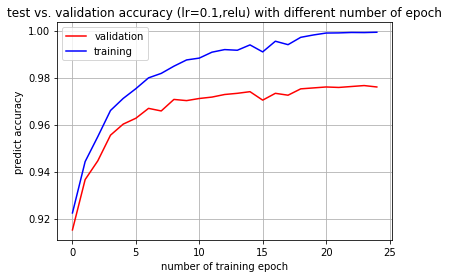

In [42]:
acu_val_3=model1['acu_val']
acu_train_3=model1['acu_train']

fig, ax = plt.subplots()
ax.plot(acu_val_3,'r',label='validation')
#ax.legend((acu_val, acu_train), ('val', 'train'))
ax.plot(acu_train_3,'b',label='training')
#ax.legend((acu_val, acu_train), ('val', 'train'))

ax.set(xlabel='number of training epoch', ylabel='predict accuracy',
       title='test vs. validation accuracy (lr=0.1,relu) with different number of epoch')
ax.grid()
ax.legend()

fig.savefig("0.1_relu.png")
plt.show()

In [43]:
ypred=pred(model1,xdata)
acc=accuracy(ypred,ydata)
print(acc)

0.9954


In [136]:
w1=model1['w1']
w2=model1['w2']
w3=model1['w3']
b1=model1['b1']
b2=model1['b2']
b3=model1['b3']

In [86]:
print(w1)

[[-0.03234209 -0.01110947 -0.00906723 ...  0.01037302  0.08558077
   0.06338536]
 [ 0.0514316  -0.03506166  0.08083081 ... -0.01749073 -0.01614734
  -0.01323596]
 [-0.01341629  0.0401466   0.07713065 ... -0.038416    0.0029892
  -0.01230262]
 ...
 [-0.01018357 -0.0055309   0.03711586 ... -0.00584602 -0.00782127
   0.00780277]
 [ 0.01910602 -0.07761323 -0.00073537 ... -0.06878197 -0.04030112
  -0.038716  ]
 [ 0.02872029 -0.02348643 -0.00955517 ...  0.08234244 -0.02768178
   0.01506031]]


In [135]:
f.close()

In [137]:
f=h5py.File('my_P2model.hdf5','w')
f.create_dataset('w1',data=w1.T)
f.create_dataset('w2',data=w2.T)
f.create_dataset('w3',data=w3.T)
f.create_dataset('b1',data=b1.reshape(400,))
f.create_dataset('b2',data=b2.reshape(70,))
f.create_dataset('b3',data=b3.reshape(10,))
f.attrs['act'] = np.string_("relu")
f.close()

In [133]:
l=h5py.File('my_P2model.hdf5','r')
list(l.keys())
l.close()
c1=l['b2']
print(c1)

ValueError: Not a location (invalid object ID)

In [134]:
l.close()